# Pylops - seismic inversion - blocky

### Author: M.Ravasi

In this notebook we will consider again the problem of post-stack seismic inversion but we will look into blocky models and how we can tailor our inversion to estimate models that satisfy this prior information.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy.signal import filtfilt

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

## 1D post-stack

Create velocity and density profiles

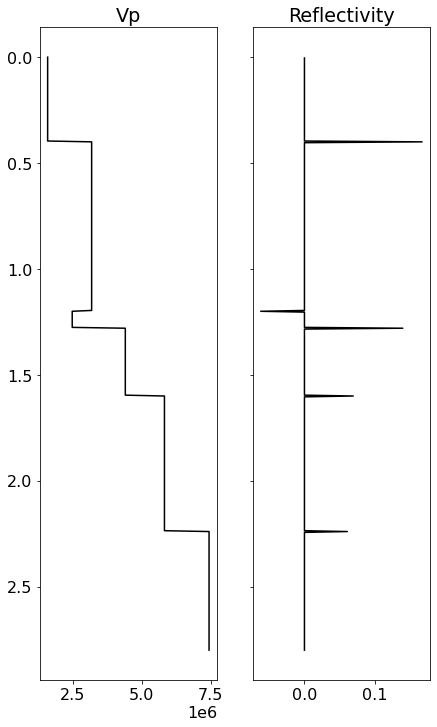

In [2]:
np.random.seed(0)

nt0 = 701
dt0 = 0.004

t0  = np.arange(nt0)*dt0
vp  = 1200*np.ones(nt0)
vp[100:300] = 1700
vp[300:320] = 1500
vp[320:400] = 2000
vp[400:550] = 2300
vp[500:560] = 2300
vp[560:]= 2600

rho=vp*1.1
ai = rho*vp

r = (ai[1:] - ai[0:-1]) / (ai[1:] + ai[0:-1])/2
m = np.log(ai)

fig, axs = plt.subplots (1, 2, figsize=(7,12), sharey=True)
axs[0].plot(ai,  t0, 'k')
axs[0].set_title('Vp')
axs[1].plot(r,  t0[1:], 'k')
axs[1].set_title('Reflectivity')
axs[1].invert_yaxis()

Define wavelet, operators and data

In [3]:
ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

In [4]:
# lop
PPop = PoststackLinearModelling(wav, nt0=nt0)
dottest(PPop, nt0, nt0, verb=True)

# dense
PPop_dense = PoststackLinearModelling(wav, nt0=nt0, explicit=True)
dottest(PPop, nt0, nt0, verb=True)

# data
d = PPop*m.flatten()
d_dense = PPop_dense*m.flatten()
dn_dense = d_dense + np.random.normal(0, 3e-2, d_dense.shape)

Dot test passed, v^H(Opu)=4.1815310715477265 - u^H(Op^Hv)=4.181531071547744
Dot test passed, v^H(Opu)=48.04117810738226 - u^H(Op^Hv)=48.04117810738224


Invert for model(s)

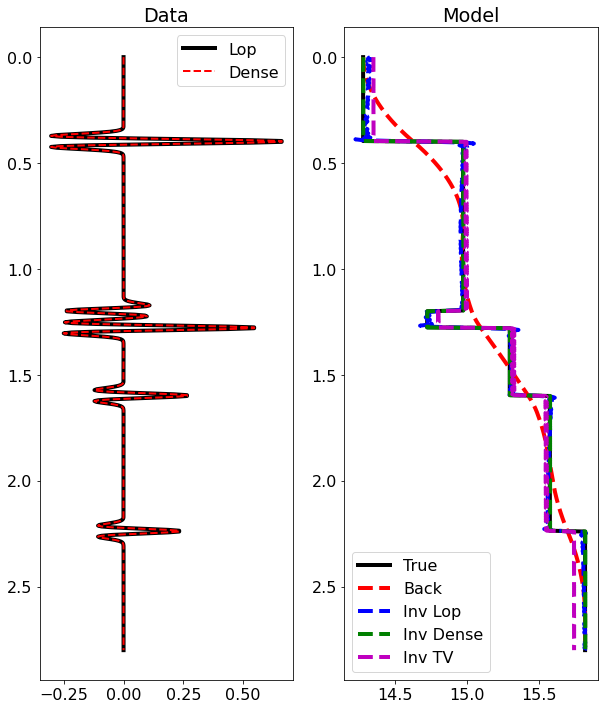

In [5]:
nsmooth = 100
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m)

# solve lop
d0 = PPop*mback
dr = d - d0
minv = lsqr(PPop, dr, iter_lim=2000)[0]
minv = mback + minv

# solve dense
d0_dense = PPop*mback
dr_dense = d_dense - d0_dense
minv_dense = lstsq(PPop_dense.A, dr_dense)[0]
minv_dense = mback + minv_dense

# solve blocky
mu = 0.01
lamda = 0.05
niter = 50
niterinner = 3
Dop = FirstDerivative(nt0, edge=True)
minv_blocky, niter_blocky = splitbregman(PPop, d_dense, [Dop], niter_outer=niter, niter_inner=niterinner, 
                                         mu=mu, epsRL1s=[lamda], x0=mback,
                                         tol=1e-4, tau=1., **dict(iter_lim=30, damp=1e-3))[:2]

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d, t0, 'k', lw=4, label='Lop')
axs[0].plot(d_dense, t0,'--r', lw=2, label='Dense')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m, t0, 'k', lw=4, label='True')
axs[1].plot(mback, t0, '--r', lw=4, label='Back')
axs[1].plot(minv, t0, '--b', lw=4, label='Inv Lop')
axs[1].plot(minv_dense, t0, '--g', lw=4, label='Inv Dense')
axs[1].plot(minv_blocky, t0, '--m', lw=4, label='Inv TV')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

Same on noisy data

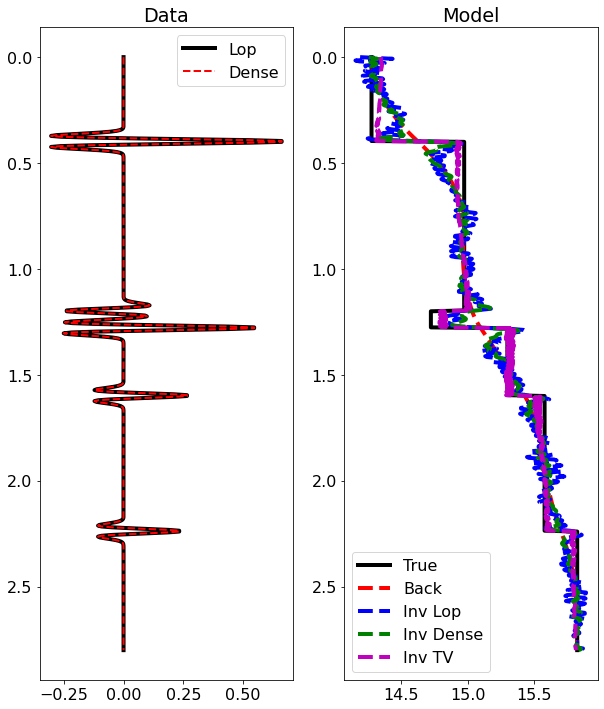

In [6]:
nsmooth = 100
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m)

# solve lop
d0 = PPop*mback
dr = dn_dense - d0
minv = lsqr(PPop, dr, damp=1e-1, iter_lim=2000)[0]
minv = mback + minv

# solve dense
d0_dense = PPop*mback
dr_dense = dn_dense - d0_dense
minv_dense = lstsq(np.dot(PPop_dense.A.T, PPop_dense.A) + 1e-1*np.eye(nt0), 
                   np.dot(PPop_dense.A.T, dr_dense))[0]
minv_dense = mback + minv_dense

# solve blocky
mu = 0.01
lamda = 0.05
niter = 5
niterinner = 10
Dop = FirstDerivative(nt0, edge=True)
minv_blocky, niter_blocky = splitbregman(PPop, dn_dense, [Dop], niter_outer=niter, niter_inner=niterinner,
                                         mu=mu, epsRL1s=[lamda], x0=mback, restart=True,
                                         tol=1e-4, tau=1., **dict(iter_lim=30, damp=1e-3))[:2]
#minv_blocky, niter_blocky = splitbregman(PPop, dn_dense, [Dop], niter_outer=niter, niter_inner=niterinner,
#                                         mu=mu, epsRL1s=[lamda], x0=mback, restart=False,
#                                         tol=1e-4, tau=1., **dict(iter_lim=10, damp=1e-3))[:2]

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d, t0, 'k', lw=4, label='Lop')
axs[0].plot(d_dense, t0,'--r', lw=2, label='Dense')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m, t0, 'k', lw=4, label='True')
axs[1].plot(mback, t0, '--r', lw=4, label='Back')
axs[1].plot(minv, t0, '--b', lw=4, label='Inv Lop')
axs[1].plot(minv_dense, t0, '--g', lw=4, label='Inv Dense')
axs[1].plot(minv_blocky, t0, '--m', lw=4, label='Inv TV')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

## 2D post-stack

In [7]:
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'], model['z'], np.log(model['model'])
nx, nz = len(x), len(z)

In [8]:
# lop
PPop = PoststackLinearModelling(wav, nt0=nz, spatdims=nx)
dottest(PPop, nz*nx, nz*nx, verb=True, atol=1e-3)

# dense
PPop_dense = PoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=True)
dottest(PPop, nz*nx, nz*nx, verb=True, atol=1e-3)

# data
d = (PPop*m.flatten()).reshape(nz,nx)
d_dense = (PPop_dense*m.flatten()).reshape(nz,nx)

n = np.random.normal(0, 1e-1, d_dense.shape)
dn = d + n
dn_dense = d_dense + n

Dot test passed, v^H(Opu)=669.3965358626866 - u^H(Op^Hv)=669.3965358626854
Dot test passed, v^H(Opu)=-1030.19134127283 - u^H(Op^Hv)=-1030.1913412728316


In [9]:
nsmooth = 60
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=1)

d_0_dense = PPop_dense*mback.flatten()
d_0_lop = PPop*mback.flatten()

In [10]:
# solve blocky
mu=.1
epsRL1s=0.1
epsRL2s=0.2
niter = 5
niterinner = 10

Dop = FirstDerivative([nz, nx], axis=0, edge=True)
Dlatop = SecondDerivative([nz, nx], axis=1, edge=True)

minv_blocky, niter_blocky = splitbregman(PPop, d.flatten(), [Dop], niter_outer=niter, niter_inner=niterinner,
                                         RegsL2=[Dlatop], 
                                         mu=.1, epsRL1s=list([epsRL1s]), epsRL2s=list([epsRL2s]), 
                                         x0=mback.ravel(), tol=1e-4, tau=1., show=True,
                                         **dict(iter_lim=5, damp=1e-3))[:2]
minv_blocky = minv_blocky.reshape(nz, nx)

minvn_blocky, nitern_blocky = splitbregman(PPop, dn.flatten(), [Dop], niter_outer=niter, niter_inner=niterinner,
                                           RegsL2=[Dlatop], 
                                           mu=.1, epsRL1s=[0.1], epsRL2s=[0.4], 
                                           x0=mback.ravel(), tol=1e-4, tau=1., show=True,
                                           **dict(iter_lim=5, damp=1e-3))[:2]
minvn_blocky = minvn_blocky.reshape(nz, nx)

SplitBregman
-----------------------------------------------------------------
The Operator Op has 440000 rows and 440000 cols
niter_outer =   5     niter_inner =  10   tol = 1.00e-04
mu = 1.00e-01         epsL1 = [0.1]	  epsL2 = [0.2]
-----------------------------------------------------------------
    Itn       x[0]           r2norm           r12norm
     1     6.0785e-01       3.650e+00        5.249e+03
     2     6.0900e-01       3.146e+00        4.789e+03
     3     6.1128e-01       3.012e+00        4.462e+03
     4     6.1438e-01       3.010e+00        4.248e+03
     5     6.1782e-01       3.071e+00        4.085e+03

Iterations = 5        Total time (s) = 24.89
-----------------------------------------------------------------

SplitBregman
-----------------------------------------------------------------
The Operator Op has 440000 rows and 440000 cols
niter_outer =   5     niter_inner =  10   tol = 1.00e-04
mu = 1.00e-01         epsL1 = [0.1]	  epsL2 = [0.4]
--------------------

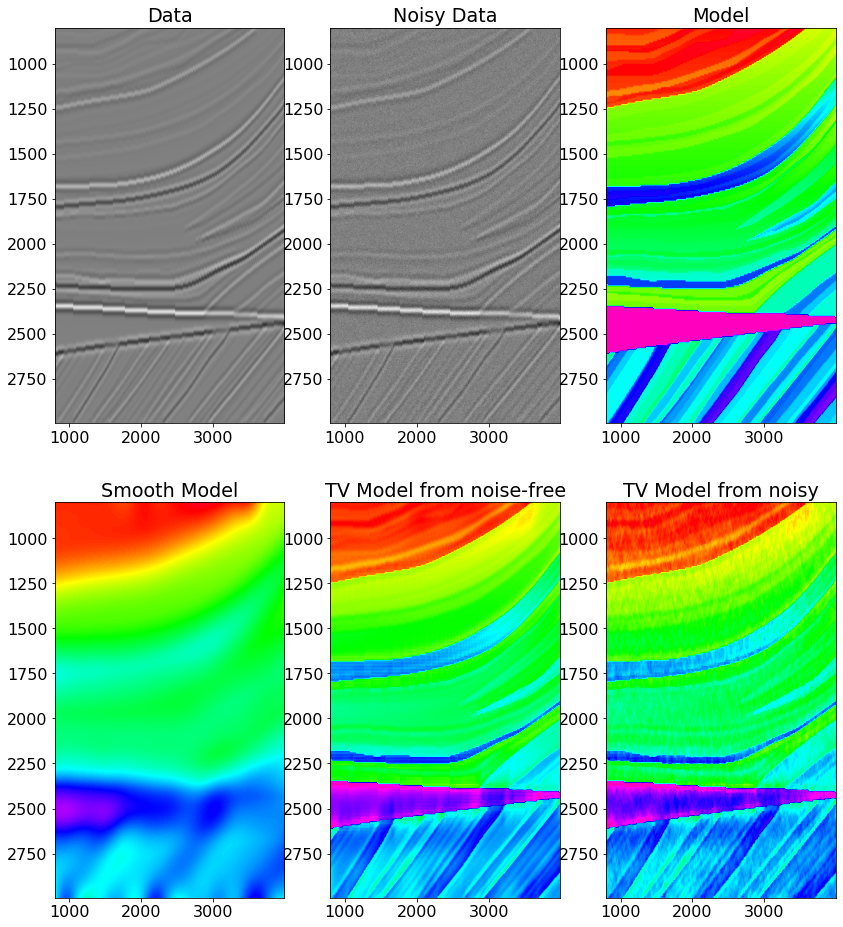

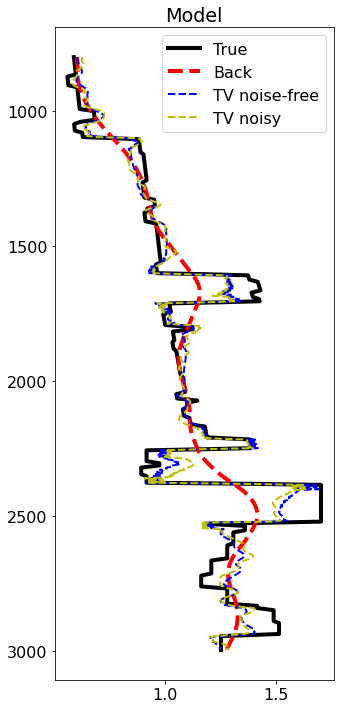

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(14,16))
axs[0][0].imshow(d, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(dn, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][1].set_title('Noisy Data')
axs[0][1].axis('tight')

axs[0][2].imshow(m, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Model')
axs[0][2].axis('tight')
axs[1][0].imshow(mback, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Smooth Model')
axs[1][0].axis('tight')
axs[1][1].imshow(minv_blocky, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[1][1].set_title('TV Model from noise-free')
axs[1][1].axis('tight')
axs[1][2].imshow(minvn_blocky, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[1][2].set_title('TV Model from noisy')
axs[1][2].axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:, nx//2], z, 'k', lw=4, label='True')
ax.plot(mback[:, nx//2], z, '--r', lw=4, label='Back')
ax.plot(minv_blocky[:, nx//2], z, '--b', lw=2, label='TV noise-free')
ax.plot(minvn_blocky[:, nx//2], z, '--y', lw=2, label='TV noisy')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

Use function

In [12]:
minv_blocky_f, dr_blocky_f = PoststackInversion(dn, wav, m0=mback, explicit=False, 
                                                epsR=[0.4], epsRL1=[0.1],
                                                **dict(mu=mu, niter_outer=niter, 
                                                       niter_inner=niterinner, show=True,
                                                       iter_lim=5, damp=1e-3))

SplitBregman
-----------------------------------------------------------------
The Operator Op has 440000 rows and 440000 cols
niter_outer =   5     niter_inner =  10   tol = 1.00e-10
mu = 1.00e-01         epsL1 = [0.1]	  epsL2 = [0.4]
-----------------------------------------------------------------
    Itn       x[0]           r2norm           r12norm
     1     5.5176e-01       2.042e+02        6.407e+03
     2     5.5595e-01       2.038e+02        5.704e+03
     3     5.6638e-01       2.040e+02        5.354e+03
     4     5.7631e-01       2.043e+02        5.094e+03
     5     5.8702e-01       2.046e+02        4.896e+03

Iterations = 5        Total time (s) = 21.29
-----------------------------------------------------------------



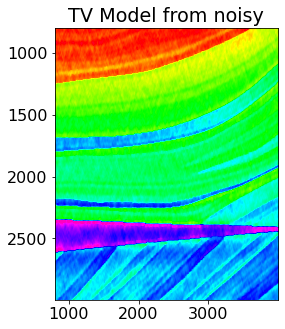

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4,5))
ax.imshow(minv_blocky_f, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
          vmin=m.min(), vmax=m.max())
ax.set_title('TV Model from noisy')
ax.axis('tight');

## 2D pre-stack

In [14]:
def plotinversion(m, mback, minv, params = ['VP', 'VS', 'Rho'], title=None):
    fig, axs = plt.subplots(3, 3, figsize=(15,12))
    fig.suptitle(title)
    for ip, param in enumerate(params):
        im=axs[0][ip].imshow(m[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                  vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[0][ip].set_title(param+' - true')
        axs[0][ip].axis('tight')
        plt.colorbar(im, ax=axs[0][ip])

        im=axs[1][ip].imshow(mback[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                             vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[1][ip].set_title(param+' - back')
        axs[1][ip].axis('tight')
        plt.colorbar(im, ax=axs[1][ip])
        im=axs[2][ip].imshow(minv[:,ip], cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]), 
                             vmin=m[:,ip].min(), vmax=m[:,ip].max())
        axs[2][ip].set_title(param+' - inv')
        axs[2][ip].axis('tight')
        plt.colorbar(im, ax=axs[2][ip])

In [15]:
inputfile='../data/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'][::3], model['z'], 1000*model['model'][:, ::3]
nx, nz = len(x), len(z)

In [16]:
mvp = m.copy()
mvs = m/2
mrho = m/3+300

In [17]:
m = np.log(np.stack((mvp, mvs, mrho),axis=1))

nt0 = 301
dt0 = 0.004
t0  = np.arange(nt0)*dt0

ntheta = 21
thetamin, thetamax = 0, 40
theta = np.linspace(thetamin, thetamax, ntheta)

ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

vsvp   = 0.5

PPop = PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nz, 
                               spatdims=(nx,), linearization='akirich')
dottest(PPop, nz*ntheta*nx, nz*3*nx, verb=True)

dPP = PPop*m.flatten()
dPP = dPP.reshape(nz,ntheta,nx)
dPPn = dPP + np.random.normal(0, 1e-1, dPP.shape)

Dot test passed, v^H(Opu)=-1570.1649980932925 - u^H(Op^Hv)=-1570.1649980932866


SplitBregman
-----------------------------------------------------------------
The Operator Op has 3083850 rows and 440550 cols
niter_outer =   3     niter_inner =   5   tol = 1.00e-10
mu = 1.00e-01         epsL1 = [0.1]	  epsL2 = [0.4, 1]
-----------------------------------------------------------------
    Itn       x[0]           r2norm           r12norm
     1     7.5392e+00       1.535e+03        6.892e+03
     2     7.5473e+00       1.531e+03        6.574e+03
     3     7.5525e+00       1.530e+03        6.316e+03

Iterations = 3        Total time (s) = 74.29
-----------------------------------------------------------------



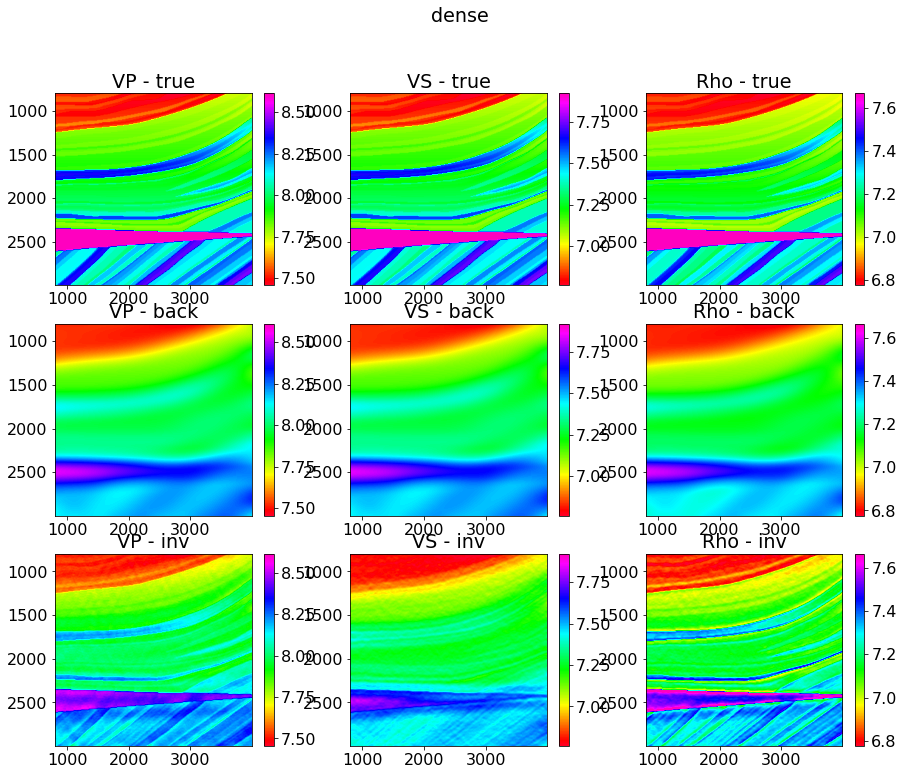

In [18]:
nsmooth = 50
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=2)

# solve blocky
mu = .1
epsRL1s = 0.1
epsRL2s = 0.4
niter = 3
niterinner = 5

#Dop = FirstDerivative([nz, 3, nx], axis=0, edge=True)
#Dlatop = SecondDerivative([nz, 3, nx], axis=2, edge=True)

#minv_blocky, niter_blocky = splitbregman(PPop, dPP.flatten(), [Dop], niter_outer=niter, niter_inner=niterinner,
#                                         RegsL2=[Dlatop], 
#                                         mu=.1, epsRL1s=list([epsRL1s]), epsRL2s=list([epsRL2s]), 
#                                         x0=mback.ravel(), tol=1e-4, tau=1., show=True,
#                                         **dict(iter_lim=5, damp=1e-3))[:2]
#minv_blocky = minv_blocky.reshape(nz, 3, nx)

minv_blocky = \
    PrestackInversion(dPPn, theta, wav, m0=mback, 
                      explicit=False, simultaneous=True, dottest=False, 
                      epsR=epsRL2s, epsI=[1e-8, 1e-2, 1e-4], 
                      epsRL1=epsRL1s, returnres=False, 
                      **dict(mu=mu, niter_outer=niter, 
                             niter_inner=niterinner, show=True,
                             iter_lim=5))

plotinversion(m, mback, minv_blocky, params = ['VP', 'VS', 'Rho'], title='dense')